# COVID-19 Variant Analysis

In [1]:
#Import dependencies
import pandas as pd
import numpy as np
import datetime
from sodapy import Socrata
from matplotlib import pyplot as plt


## Get the Variant Data from API

In [2]:
# Get Data from the API
client = Socrata("data.cdc.gov", None)

# Initialize empty list to store all results
all_results = []

# Parameters for pagination
offset = 0
limit = 10000

while True:
    # Fetch a chunk of data
    results_chunk = client.get("jr58-6ysp", content_type="json", select="variant, creation_date, share, week_ending, usa_or_hhsregion", limit=limit, offset=offset)
    
    # If chunk is empty or smaller than limit, stop fetching
    if not results_chunk or len(results_chunk) < limit:
        all_results.extend(results_chunk)
        break
    
    # Otherwise, add chunk to all results and increment the offset
    all_results.extend(results_chunk)
    # Print running statement to check if we are looping through the API
    print('running...')
    offset += limit

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(all_results)

# Display tail to make sure we get max rows
results_df.tail(5)

running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...

,variant,creation_date,share,week_ending,usa_or_hhsregion
1078797,BN.1,2022-12-09T00:00:00.000,0.023594103753566742,2022-11-19T00:00:00.000,10
1078798,BQ.1,2022-12-09T00:00:00.000,0.20200251042842865,2022-11-19T00:00:00.000,10
1078799,BQ.1.1,2022-12-09T00:00:00.000,0.17415671050548553,2022-11-19T00:00:00.000,10
1078800,Other,2022-12-09T00:00:00.000,0.0,2022-11-19T00:00:00.000,10
1078801,XBB,2022-12-09T00:00:00.000,0.028597155585885048,2022-11-19T00:00:00.000,10


## Clean the data 

In [3]:
# Create a column for the prefix only
results_df['variant_prefix'] = results_df['variant'].str.split('.').str[0]

# Convert the appropriate columns to python datetime
results_df['week_ending'] = pd.to_datetime(results_df['week_ending'], format='%Y-%m-%dT%H:%M:%S.%f')
results_df['creation_date'] = pd.to_datetime(results_df['creation_date'], format='%Y-%m-%dT%H:%M:%S.%f')


In [4]:
# Get all the latest dates for creation_date
latest_dates_df = results_df.groupby(['week_ending', 'usa_or_hhsregion'])['creation_date'].max().reset_index()

# Merge with the original dataframe to get rows with the latest creation_date for each combination
filtered_df = pd.merge(results_df, latest_dates_df, on=['week_ending', 'usa_or_hhsregion', 'creation_date'])

# Reset the index
filtered_df = filtered_df.reset_index(drop=True)



In [5]:
# rename columns and convert the Share column to be in percentage 
filtered_df.rename(columns={'share' : 'Share (%)', 'creation_date' : 'published_date'}, inplace=True)
filtered_df['Share (%)'] = filtered_df['Share (%)'].astype(float) * 100

In [6]:
# Copy the dataframe to a new one called region_df for further manipulation
region_df = filtered_df.copy()

In [7]:
# Define a dictionary to rename the regions to their actual regional names in case you want to use this later
region_mapping = {
    "1": "Region 1 - Boston",
    "2": "Region 2 - New York",
    "3": "Region 3 - Philadelphia",
    "4": "Region 4 - Atlanta",
    "5": "Region 5 - Chicago",
    "6": "Region 6 - Dallas",
    "7": "Region 7 - Kansas City",
    "8": "Region 8 - Denver",
    "9": "Region 9 - San Francisco",
    "10": "Region 10 - Seattle",
}



In [8]:
# Set up dataframe to group by region
region_df['usa_or_hhsregion'].replace(region_mapping, inplace=True)
region_df['Year'] = region_df['week_ending'].dt.year
region_df.sort_values(by='week_ending', inplace=True)
region_df.reset_index(drop=True, inplace=True)
region_df.tail()

,variant,published_date,Share (%),week_ending,usa_or_hhsregion,variant_prefix,Year
49476,XBB.1.16.1,2023-09-29,2.941565,2023-09-30,Region 5 - Chicago,XBB,2023
49477,XBB.1.5.70,2023-09-29,4.017762,2023-09-30,Region 5 - Chicago,XBB,2023
49478,XBB.1.5.68,2023-09-29,0.591751,2023-09-30,Region 5 - Chicago,XBB,2023
49479,FD.2,2023-09-29,0.004870,2023-09-30,Region 5 - Chicago,FD,2023
49480,XBB.2.3,2023-09-29,6.664648,2023-09-30,Region 9 - San Francisco,XBB,2023


## Plot Variant % over time for USA (Limit to top variants)

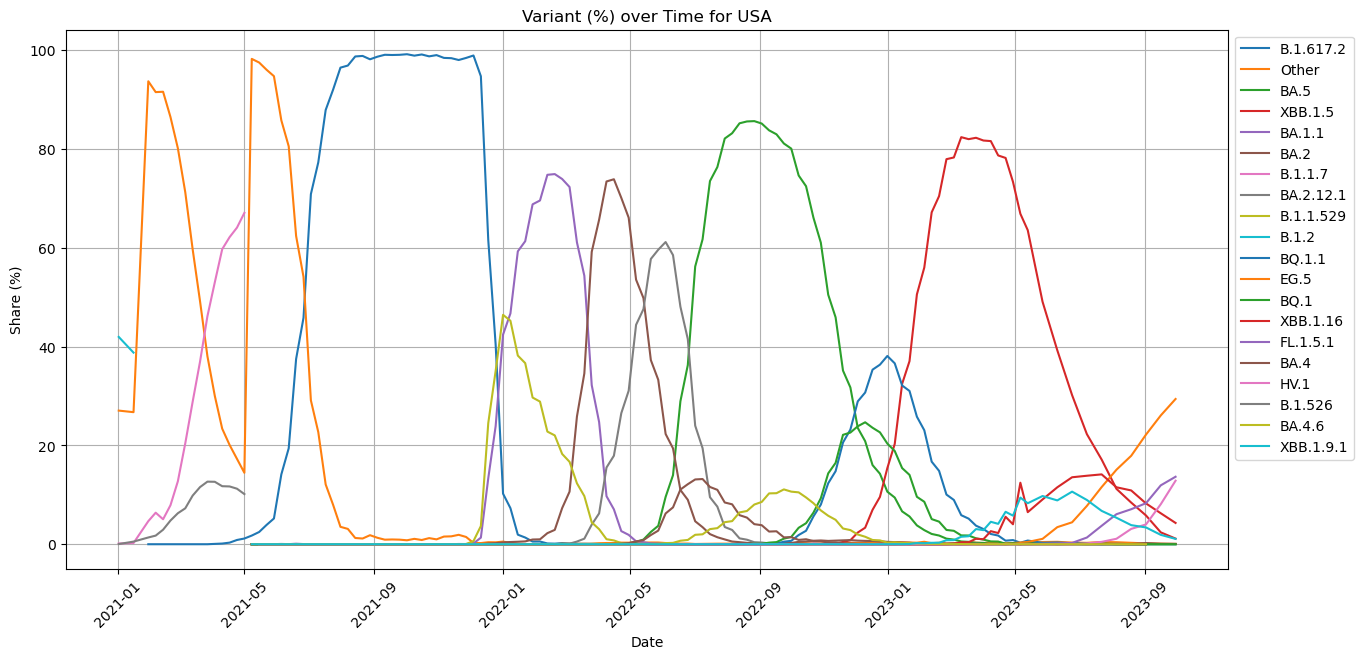

In [9]:
# Extracting the Share (%) values for each combination
grouped_data = region_df.groupby(['variant', 'usa_or_hhsregion','week_ending'])['Share (%)'].sum()

# Selecting the specific region 'USA'
region = 'USA'
plt.figure(figsize=(15, 7))

# Get data specific to 'USA'
region_data = grouped_data[:, region, :]

# Determine the top 20 variant_prefixes based on their maximum Share (%)
top_variants = region_data.groupby(level=0).max().nlargest(20).index

# Loop through each variant_prefix in the top_variants and plot its trend
for variant in top_variants:
    data = region_data.xs(variant, level='variant')
    plt.plot(data.index, data.values, label=variant)

# Setting plot details
plt.title(f'Variant (%) over Time for {region}')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))  # Placing legend outside the plot for clarity
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

### Compare each regions distribution of variants to each other to see which variants are most prevalent in which region.

In [10]:
# Filter data to get the start of quarter (SOQ) variant distribution for each of the years.
# Loop through the dataframe and

unique_years = region_df['Year'].unique()
dfs_by_year = {}

for year in unique_years:
    # Filter by year 
    yearly_df = region_df[region_df['Year'] == year]

    # Identify SOQ rows: January, April, July, and October
    temp_filtered_df = yearly_df[yearly_df['week_ending'].dt.month.isin([1, 4, 7, 10])]

    # Get only the first date for each month 
    soq_dates = temp_filtered_df.groupby(temp_filtered_df['week_ending'].dt.month).min()['week_ending'].reset_index(drop=True)

    # Use merge to filter rows from yearly_df that match the SOQ dates
    merged_df = yearly_df.merge(soq_dates, on='week_ending', how='inner')

    # Reset the index
    merged_df = merged_df.reset_index(drop=True)

    # Store this merged dataframe in the dictionary
    dfs_by_year[year] = merged_df

In [11]:
# Mapping of months to reflect start of the quarters
quarter_mapping = {
    1: "Q1 Start",
    4: "Q2 Start",
    7: "Q3 Start",
    10: "Q4 Start"
}

grouped_by_quarter = {}

for year, df in dfs_by_year.items():
    # For each unique start-of-quarter date
    for date in df['week_ending'].unique():
        # Use the month to determine the quarter
        quarter = quarter_mapping[date.month]
        
        # Construct a key based on the year and the quarter
        key = f"{year}: {quarter}"  # This will now create keys like "2023: Q1 Start"
        
        # Filter the dataframe by this date
        filtered_df = df[df['week_ending'] == date]
        
        # Group by the required columns
        grouped = filtered_df.groupby(['variant', 'usa_or_hhsregion'])
        
        grouped_by_quarter[key] = grouped

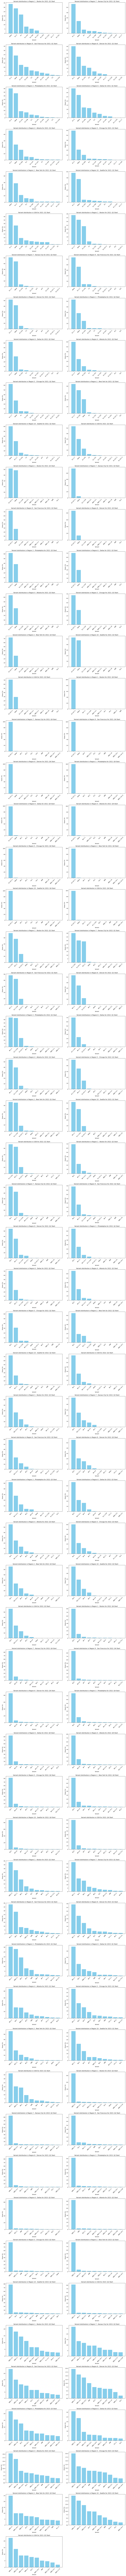

In [18]:
#Getting unique regions
regions = region_df['usa_or_hhsregion'].unique()

#Reordering this array correctly
index_10 = np.where(regions == "Region 10 - Seattle")[0]
# If the item exists
if index_10.size:
    # Remove "Region 10 - Seattle" from its current position
    regions = np.delete(regions, index_10)
    
    # Insert "Region 10 - Seattle" to the second to last position
    regions = np.insert(regions, -1, "Region 10 - Seattle")
    
n = len(grouped_by_quarter) * len(regions)
cols = 2  # number of columns for the grid
rows = (n // cols) + (n % cols > 0)  # calculate the required number of rows

# Set up a figure with a grid of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5 * rows))

# Flatten the axes array to easily iterate over it
flattened_axes = axes.ravel()

index = 0
for year, grouped in grouped_by_quarter.items():
    for region in regions:
        data = grouped['Share (%)'].mean().unstack()[region].sort_values(ascending=False)

        # Limit data to the top 10 highest values
        data = data.head(10)
        
        ax = flattened_axes[index]
        ax.bar(data.index, data, color='skyblue')
        ax.set_title(f'Variant distribution in {region} for {year}')
        ax.set_ylabel('Share (%)')
        ax.set_xlabel('Variant')
        ax.tick_params(axis='x', rotation=45)  # Rotate x-labels for better visibility
        
        index += 1

# Hide any remaining unused subplots
for i in range(index, rows * cols):
    flattened_axes[i].axis('off')

plt.tight_layout()  # Adjust layout for better fit
plt.show()